# Using Q-Learning to solve CartPole

## Import necessary libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

## Load the CartPole environment

In [2]:
env = gym.make('CartPole-v1')

print(env.observation_space) # 观测空间，4个观测量，取值范围不同
print(env.action_space.n) # 动作空间 2个动作

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
2


In [3]:
env.reset()

(array([0.00180166, 0.01598316, 0.03859593, 0.03444824], dtype=float32), {})

In [4]:
env.step(0)

/Users/xiyan/anaconda3/envs/my_rl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([ 0.00212132, -0.17967041,  0.0392849 ,  0.3390544 ], dtype=float32),
 1.0,
 False,
 False,
 {})

**It should be noted that, for some versions of gym, there is always an empty dictionary at the end of return from env.reset/step().**

From [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), you can find the basic settings of the enviroment.

## Create a Q-table and discretize the observation space
Since the enciroment possesses a continuous observation space that is impossible for Q-table to record, bins will be used to discrete it.

Considering the difference in significance of distinct variables, the dimensions of bins `bins_size` were designed as $[50,30,50,30]$.


In [5]:
state_space = 4 # number of states
action_space = 2 # number of possible actions
bins_size = [50,30,50,30] # for discretized observation space

# set bins as well as create and initialize a Q-table
def Qtable(state_space,action_space,bins_size):
    
    bins = [np.linspace(-4.8,4.8,bins_size[0]),
            np.linspace(-4,4,bins_size[1]),
            np.linspace(-0.418,0.418,bins_size[2]),
            np.linspace(-4,4,bins_size[3])]
    
    q_table = np.random.uniform(low=-1,high=1,size=(bins_size + [action_space]))
    return q_table, bins

# convert a continuous state to discrete one
def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

## Define the epsilon-greedy policy for training

In [6]:
def epsilon_greedy_policy(qtable, current_state, epsilon):
    if np.random.uniform(0,1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_table[current_state])
    return action

## Set training parameters

In [7]:
episodes = 10000 # run times
timestep = 200 # checkpoints

# Q-learning
gamma = 0.95 # dicounted rate
lr = 0.1 # learning rate

# decaying epsilon
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

## Train

In [8]:
def Q_learning(q_table, bins, episodes, gamma, lr, timestep, max_epsilon, min_epsilon, decay_rate):
    
    rewards = 0 # total rewards of multiple consecutive episodes
    prev_steps = [] # to record the number of steps (or total reward) for every episode
    metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph
    
    for episode in range(1,episodes+1):
        
        state_init, _ = env.reset()
        current_state = Discrete(state_init, bins)
      
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        score = 0 # total reward of each episode
        done = False
        steps = 0
        while not done:
            steps += 1
            if episode%timestep==0: env.render()
                
            action = epsilon_greedy_policy(q_table, current_state, epsilon) # get action
            
            # interact
            observation, reward, done, info, _ = env.step(action)
            
            #if episode == 60000: print("episode:",60000,"step:",steps,"action:",action,"reward:",reward,"done:",done)
                
            next_state = Discrete(observation,bins)
            score+=reward
          
            if not done:
                # Note: in this logic, there is no update for qtable at the last step
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)] # concat tuple as index
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q
                
                current_state = next_state
            
        
        # after one episode ending
        prev_steps.append(steps)
        rewards += score
        if episode % timestep == 0:
            latestRuns = prev_steps[-timestep:]
            averageCnt = sum(latestRuns) / len(latestRuns)
            metrics['ep'].append(episode)
            metrics['avg'].append(averageCnt)
            metrics['min'].append(min(latestRuns))
            metrics['max'].append(max(latestRuns))
            print(episode,':','steps',steps,'score',score)
            
        # Every 1000 rounds, print the average cumulative reward per round        
        if episode % (5*timestep) == 0: 
            print(episode,':','average reward for last 1000 runs:', rewards / 1000)
            rewards = 0;
    return metrics

In [9]:
q_table, bins = Qtable(state_space,action_space,bins_size)
metrics = Q_learning(q_table, bins, episodes, gamma, lr, timestep, max_epsilon, min_epsilon, decay_rate)

200 : steps 11 score 11.0


/Users/xiyan/anaconda3/envs/my_rl/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


400 : steps 14 score 14.0
600 : steps 30 score 30.0
800 : steps 38 score 38.0
1000 : steps 33 score 33.0
1000 : average reward for last 1000 runs: 28.069
1200 : steps 27 score 27.0
1400 : steps 34 score 34.0
1600 : steps 30 score 30.0
1800 : steps 62 score 62.0
2000 : steps 62 score 62.0
2000 : average reward for last 1000 runs: 47.729
2200 : steps 28 score 28.0
2400 : steps 118 score 118.0
2600 : steps 122 score 122.0
2800 : steps 58 score 58.0
3000 : steps 17 score 17.0
3000 : average reward for last 1000 runs: 74.15
3200 : steps 50 score 50.0
3400 : steps 248 score 248.0
3600 : steps 128 score 128.0
3800 : steps 38 score 38.0
4000 : steps 194 score 194.0
4000 : average reward for last 1000 runs: 92.39
4200 : steps 80 score 80.0
4400 : steps 110 score 110.0
4600 : steps 126 score 126.0
4800 : steps 145 score 145.0
5000 : steps 84 score 84.0
5000 : average reward for last 1000 runs: 107.71
5200 : steps 171 score 171.0
5400 : steps 80 score 80.0


KeyboardInterrupt: 

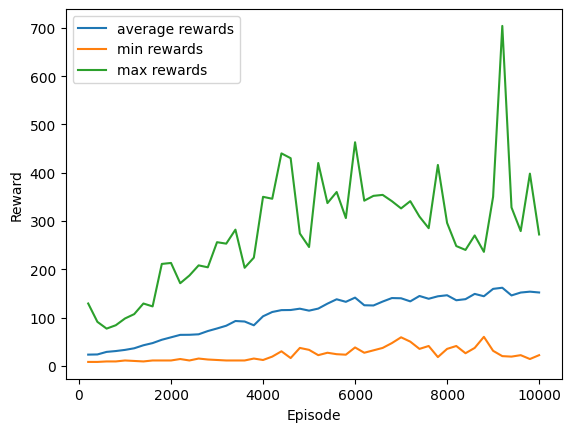

In [ ]:
# Plot graph
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=0)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('./Figures/q-learning1.png')
plt.show()

## Modification
In the above algorithm, noting that there is no update for qtable at the last step of each episode. However, it is clear that this is not a wise course of action. So a modification is added, specifically, considering a penalty.

In [ ]:
def Q_learning1(q_table, bins, episodes, gamma, lr, timestep, max_epsilon, min_epsilon, decay_rate):

    rewards = 0
    prev_steps = [] # to record the number of steps (or total reward) for every episode
    metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph
    
    for episode in range(1,episodes+1):
        
        # env.reset() => initial observation
        state_init, _ = env.reset()
        current_state = Discrete(state_init, bins)
      
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        score = 0
        done = False
        steps = 0
        while not done:
            steps += 1
            if episode%timestep==0: env.render()
                
            action = epsilon_greedy_policy(q_table, current_state, epsilon)
            
            
            observation, reward, done, info, _ = env.step(action)
            #if episode == 10000: print("episode:",10000,"step:",steps,"action:",action,"reward:",reward,"done:",done)
                
            next_state = Discrete(observation,bins)
            score+=reward 
          
            # 对未达200次，导致terminate的行动给予惩罚(该reward只参与最后一步的qtable更新，不作为累计reward：score)
            # Note: in this logic, a penalty is given to the last action that directly contribute to the termination, which is involved in the last update of the q-table 
            if done and steps<200:
                reward = -375
                
            max_future_q = np.max(q_table[next_state])
            current_q = q_table[current_state+(action,)]
            new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
            q_table[current_state+(action,)] = new_q
                
            current_state = next_state
            
        # after one episode ending
        prev_steps.append(steps)
        rewards += score
        if episode % timestep == 0:
            latestRuns = prev_steps[-timestep:]
            averageCnt = sum(latestRuns) / len(latestRuns)
            metrics['ep'].append(episode)
            metrics['avg'].append(averageCnt)
            metrics['min'].append(min(latestRuns))
            metrics['max'].append(max(latestRuns))
            print(episode,':','steps',steps,'score',score)
                    
                
        if episode % (5*timestep) == 0: 
            print(episode,':','average_rewards pre 400 runs:', rewards / 1000)
            rewards = 0;
    return metrics

In [ ]:
q_table1, bins1 = Qtable(state_space,action_space,bins_size)
metrics1 = Q_learning1(q_table, bins, episodes, gamma, lr, timestep, max_epsilon, min_epsilon, decay_rate)

200 : steps 39 score 39.0
400 : steps 104 score 104.0
600 : steps 32 score 32.0
800 : steps 13 score 13.0
1000 : steps 136 score 136.0
1000 : average_rewards pre 400 runs: 32.533
1200 : steps 46 score 46.0
1400 : steps 31 score 31.0
1600 : steps 37 score 37.0
1800 : steps 16 score 16.0
2000 : steps 36 score 36.0
2000 : average_rewards pre 400 runs: 68.855
2200 : steps 147 score 147.0
2400 : steps 148 score 148.0
2600 : steps 101 score 101.0
2800 : steps 120 score 120.0
3000 : steps 147 score 147.0
3000 : average_rewards pre 400 runs: 111.081
3200 : steps 75 score 75.0
3400 : steps 81 score 81.0
3600 : steps 147 score 147.0
3800 : steps 80 score 80.0
4000 : steps 103 score 103.0
4000 : average_rewards pre 400 runs: 136.788
4200 : steps 122 score 122.0
4400 : steps 87 score 87.0
4600 : steps 403 score 403.0
4800 : steps 175 score 175.0
5000 : steps 128 score 128.0
5000 : average_rewards pre 400 runs: 156.965
5200 : steps 161 score 161.0
5400 : steps 197 score 197.0
5600 : steps 161 score

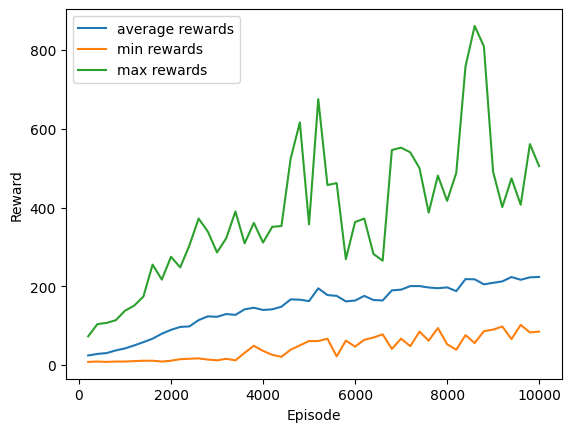

In [ ]:
# Plot graph
plt.plot(metrics1['ep'], metrics1['avg'], label="average rewards")
plt.plot(metrics1['ep'], metrics1['min'], label="min rewards")
plt.plot(metrics1['ep'], metrics1['max'], label="max rewards")
plt.legend(loc=0)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('./Figures/q-learning2.png')
plt.show()

**Better!**

## References
[1]https://medium.com/analytics-vidhya/q-learning-is-the-most-basic-form-of-reinforcement-learning-which-doesnt-take-advantage-of-any-8944e02570c5

[2]https://github.com/JackFurby/CartPole-v0/tree/master

[3]https://medium.com/swlh/using-q-learning-for-openais-cartpole-v1-4a216ef237df

[4][An Introduction to Q-Learning: A Tutorial For Beginners](https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial)